In [ ]:
# Connect Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Importing Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import time

# Plotting Libraries Import
import matplotlib.pyplot as plt
import seaborn as sns
# The %matplotlib inline command tells the Jupyter Notebook to display plots inline, within the notebook itself.
%matplotlib inline

# ML Model Class Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Hyperparameter Tuning Imports
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

# Metrics for Evaluation
from sklearn.metrics import roc_curve, auc, confusion_matrix, log_loss


# Reading Data

In [2]:
# Loading saved data
with open("data/X_tr_set2.pkl", "rb") as f:
    X_tr_set2 = pickle.load(f)

with open("data/X_te_set2.pkl", "rb") as f:
    X_te_set2 = pickle.load(f)

with open("data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

with open("data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Utility Functions

In [3]:
# we own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

In [4]:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [5]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])

    return y_data_pred

In [6]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j

    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column

    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1

    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]]
    plt.figure(figsize=(20,4))

    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

# Model Building

## 1. KNN [Do not run, takes a lot of time.]

### Hyperparameter Optimization 

In [7]:
# Training on CPU. Very slow. Sklearn doesn't support GPU Acceleration

# Running a K-Nearest Neighbors (KNN) classifier with RandomizedSearchCV in scikit-learn on a GPU for increased speed is a bit complex, primarily because
# scikit-learn does not natively support GPU acceleration.

start_time = time.time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[3, 15, 25, 51, 101]}
clf = RandomizedSearchCV(neigh, parameters, cv=5, scoring='roc_auc')
clf.fit(X_tr_set2, y_train)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

# Having a look at the results

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score']
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

clf.best_estimator_
# This takes lot of time to run. 

# Output is 
# KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#                      metric_params=None, n_jobs=-1, n_neighbors=101, p=2,
#                      weights='uniform')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


### Model Training and Prediction

In [7]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=101, p=2,
                     weights='uniform')

knn.fit(X_tr_set2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(knn, X_tr_set2)
y_test_pred = batch_predict(knn, X_te_set2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("ROC")
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### Evaluation

In [ ]:
print("="*100)

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

y_pred_train1 = predict_with_best_t(y_train_pred, best_t)

y_pred_test1= predict_with_best_t(y_test_pred, best_t)

#### Confusion matrix on Train Data

In [ ]:
plot_confusion_matrix(y_train, y_pred_train1)

#### Confusion matrix on Test Data

## 2. Naive Bayes

In [ ]:
plot_confusion_matrix(y_test, y_pred_test1)

### Hyperparameter Optimization

In [7]:
neigh = MultinomialNB()
parameters = {'alpha': [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.5, 1,5, 10, 50, 100]}
clf = RandomizedSearchCV(neigh, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr_set2, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score']
cv_auc_std= results['std_test_score'] #since randomclassier has cv of 5 we are mentioning it as cv_auc while it is test score basically
K =  results['param_alpha'] #k is different values of alpha i.e our smoothning parameter.

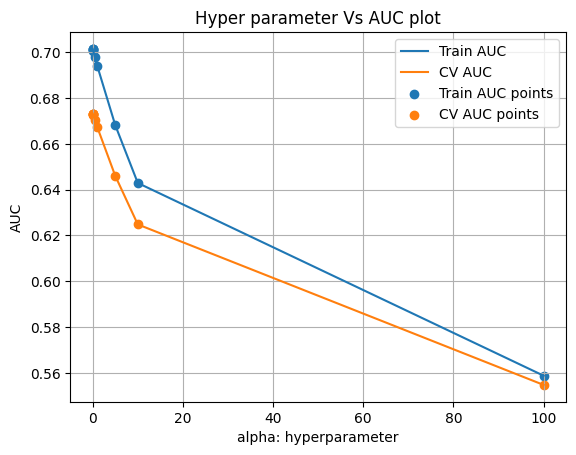

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,0.026572,0.002334,0.011147,0.000317,0.00001,{'alpha': 1e-05},0.670565,0.664949,0.681080,0.682273,...,0.673231,0.007133,1,0.702711,0.703922,0.700810,0.698179,0.701540,0.701432,0.001940
4,0.026514,0.000517,0.011410,0.000074,0.001,{'alpha': 0.001},0.670558,0.664944,0.681075,0.682267,...,0.673225,0.007133,2,0.702704,0.703915,0.700803,0.698171,0.701532,0.701425,0.001940
2,0.027528,0.001070,0.011481,0.000431,0.01,{'alpha': 0.01},0.670500,0.664896,0.681028,0.682204,...,0.673171,0.007131,3,0.702635,0.703849,0.700737,0.698102,0.701466,0.701358,0.001941
3,0.025869,0.000846,0.011114,0.000331,0.05,{'alpha': 0.05},0.670251,0.664707,0.680818,0.681912,...,0.672933,0.007115,4,0.702328,0.703554,0.700437,0.697799,0.701169,0.701058,0.001942
9,0.026021,0.000372,0.011019,0.000173,0.1,{'alpha': 0.1},0.669956,0.664465,0.680555,0.681571,...,0.672643,0.007101,5,0.701950,0.703184,0.700065,0.697418,0.700802,0.700684,0.001945


In [8]:
# we are transfroming K to log(K) for better readability
import math
def log(x):
    return math.log(x)

K_ =  results['param_alpha'].apply(log)

#without log scale
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

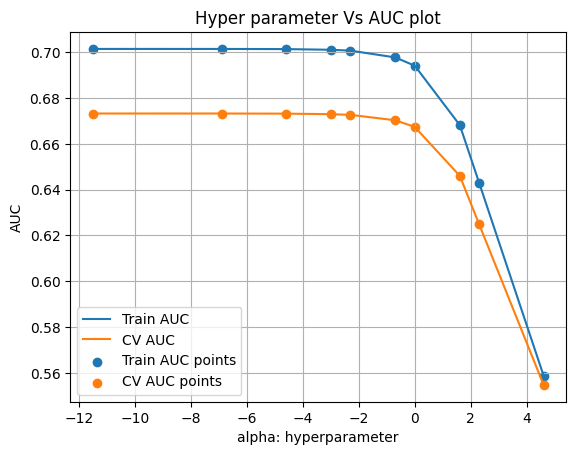

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,0.026572,0.002334,0.011147,0.000317,0.00001,{'alpha': 1e-05},0.670565,0.664949,0.681080,0.682273,...,0.673231,0.007133,1,0.702711,0.703922,0.700810,0.698179,0.701540,0.701432,0.001940
4,0.026514,0.000517,0.011410,0.000074,0.001,{'alpha': 0.001},0.670558,0.664944,0.681075,0.682267,...,0.673225,0.007133,2,0.702704,0.703915,0.700803,0.698171,0.701532,0.701425,0.001940
2,0.027528,0.001070,0.011481,0.000431,0.01,{'alpha': 0.01},0.670500,0.664896,0.681028,0.682204,...,0.673171,0.007131,3,0.702635,0.703849,0.700737,0.698102,0.701466,0.701358,0.001941
3,0.025869,0.000846,0.011114,0.000331,0.05,{'alpha': 0.05},0.670251,0.664707,0.680818,0.681912,...,0.672933,0.007115,4,0.702328,0.703554,0.700437,0.697799,0.701169,0.701058,0.001942
9,0.026021,0.000372,0.011019,0.000173,0.1,{'alpha': 0.1},0.669956,0.664465,0.680555,0.681571,...,0.672643,0.007101,5,0.701950,0.703184,0.700065,0.697418,0.700802,0.700684,0.001945


In [10]:
#with log scale, which increases the readabilty of the plot

plt.plot(K_, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K_, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K_, train_auc, label='Train AUC points')
plt.scatter(K_, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

### Model Training and  Prediction

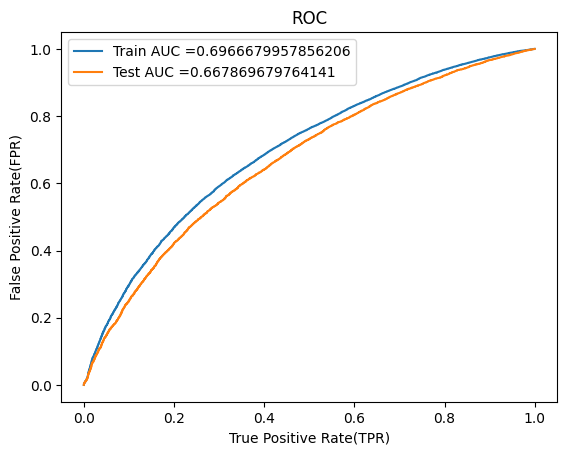

In [9]:
nb_bow = MultinomialNB(alpha = 0.0001)

nb_bow.fit(X_tr_set2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(nb_bow, X_tr_set2)
y_test_pred = batch_predict(nb_bow, X_te_set2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("ROC")
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

`Conclusion : With alpha = 0.001 we get train AUC = 0.69 and test AUC = 0.67`

### Model Evaluation

In [11]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_train1 = predict_with_best_t(y_train_pred, best_t)

y_pred_test1 = predict_with_best_t(y_test_pred, best_t)

the maximum value of tpr*(1-fpr) 0.4170747299217566 for threshold 0.851


#### Evaluation on Train Data

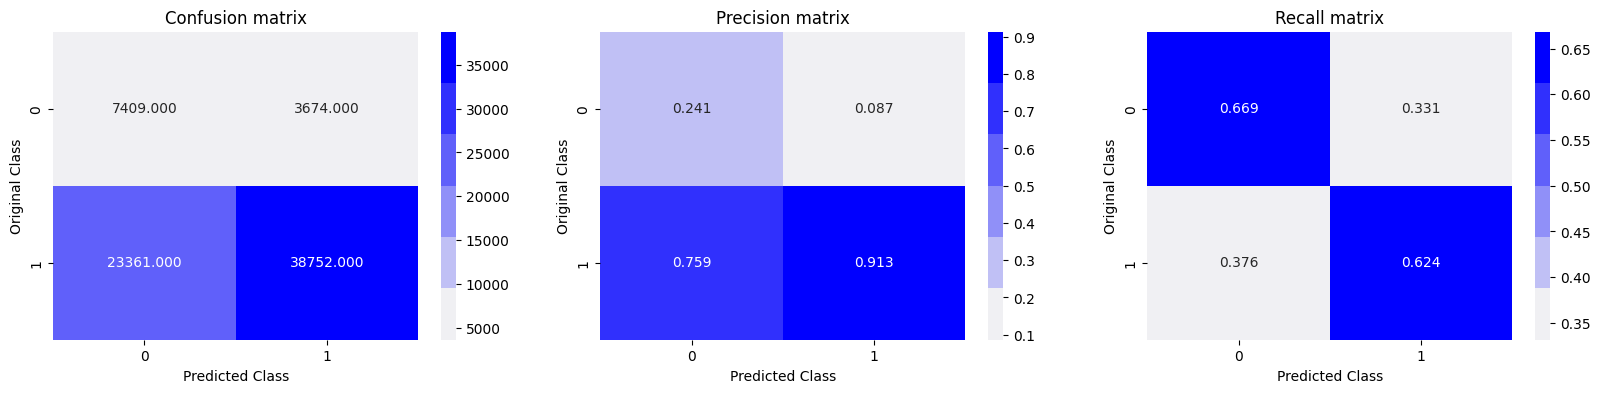

In [12]:
plot_confusion_matrix(y_train, y_pred_train1)

#### Evaluation on Test Data

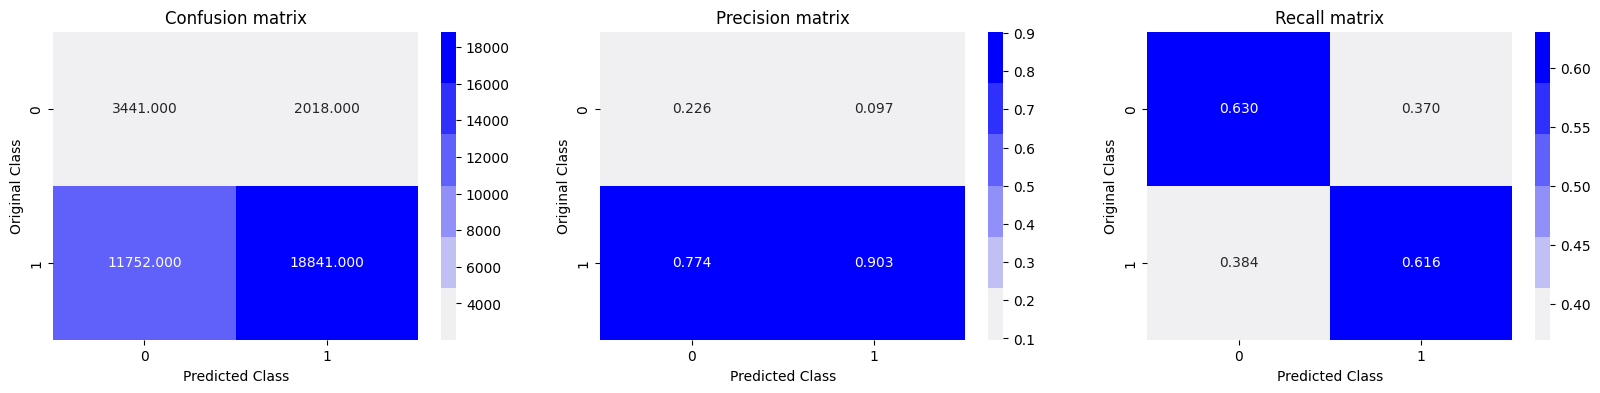

In [13]:
plot_confusion_matrix(y_test, y_pred_test1)

` Conclusion : We are predicting a lot of False Negatives `

## 3. Logistic Regression

We can also use LogisticRegression class for logistic regression models, and it's often a more straightforward choice compared to using SGDClassifier with the logistic loss. Both are available in scikit-learn and can be used for logistic regression, but they have some differences in their approach and use-cases.

LogisticRegression
Implementation: The LogisticRegression class in scikit-learn uses more traditional optimization methods like Newton’s Method, L-BFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno), and others.
Use Case: It's more suitable for smaller datasets or datasets that fit into memory, as the optimization algorithms it uses require the entire dataset to be in memory.
Ease of Use: It's generally easier to use for logistic regression tasks, as it's specifically designed for this purpose. You don't need to specify a loss function because it's implicitly logistic regression.
Regularization: Offers L1, L2, or Elastic-Net regularization directly through its parameters.

SGDClassifier
Implementation: SGDClassifier stands for Stochastic Gradient Descent Classifier. As the name suggests, it implements a linear classifier with stochastic gradient descent learning. The loss function can be adjusted to use log_loss for logistic regression.
Use Case: It's more suitable for large-scale and sparse data and online learning, as SGD does not require the entire dataset to be in memory and works well with partial data.
Flexibility: It's more flexible in terms of the types of problems it can solve, as you can change the loss function to adapt to different linear models (e.g., SVM, logistic regression).
Regularization: Supports different types of regularization like L2, L1, or Elastic-Net, but the choice of regularization might depend on the loss function.

Choosing Between Them
For logistic regression tasks, if your dataset is not extremely large and fits comfortably in memory, LogisticRegression is typically the more straightforward and appropriate choice.
If you are dealing with very large datasets or require online learning (processing the data in increments), SGDClassifier with loss='log_loss' might be more suitable.

### Hyperparameter Tuning

In [17]:
lr = SGDClassifier(loss='log_loss', random_state=42)
parameters = {'alpha': [10 ** x for x in range(-5, 2)], 'penalty' : ['l1', 'l2']}
clf = RandomizedSearchCV(lr, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr_set2, y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)

In [18]:
#These are our best parameters
clf.best_estimator_

SGDClassifier(alpha=1e-05, loss='log_loss', penalty='l1', random_state=42)

In [28]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparameter for SGD classifier.

log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(X_tr_set2, y_train)  # Fit the SGDClassifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr_set2, y_train)  # Fit the CalibratedClassifierCV
    predict_y = sig_clf.predict_proba(X_te_set2)  # Now you can make predictions
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of alpha =  1e-05 The log loss is: 0.38629059501096036
For values of alpha =  0.0001 The log loss is: 0.38668480800063393
For values of alpha =  0.001 The log loss is: 0.406801288390679
For values of alpha =  0.01 The log loss is: 0.4204253892614838
For values of alpha =  0.1 The log loss is: 0.42308243554407715
For values of alpha =  1 The log loss is: 0.42356335565877906
For values of alpha =  10 The log loss is: 0.4236302034729176


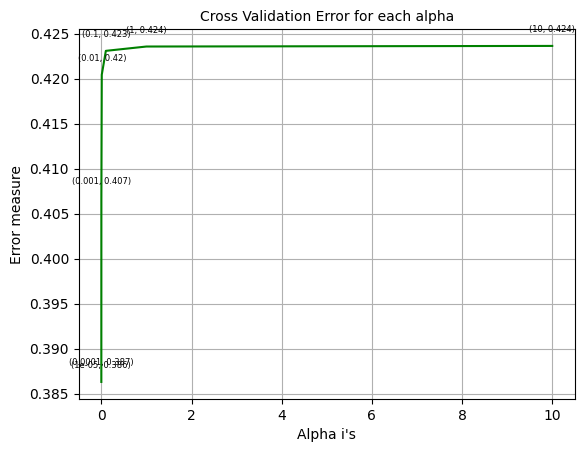

In [50]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='g')

# Offsetting annotations and adjusting alignment
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate(
        (alpha[i], np.round(txt, 3)), 
        (alpha[i], log_error_array[i]),
        textcoords="offset points",  # Positioning text
        xytext=(0,10),  # Distance from text to points (x,y)
        ha='center',  # Horizontal alignment
        fontsize=6)
plt.grid(markersize = 2)
plt.title("Cross Validation Error for each alpha", fontsize = 10)
plt.xlabel("Alpha i's", fontsize = 10)
plt.ylabel("Error measure", fontsize = 10)
plt.show()

For values of best alpha =  1e-05 The train log loss is: 0.35676408999043213
For values of best alpha =  1e-05 The test log loss is: 0.38629059501096036
Total number of data points : 36052


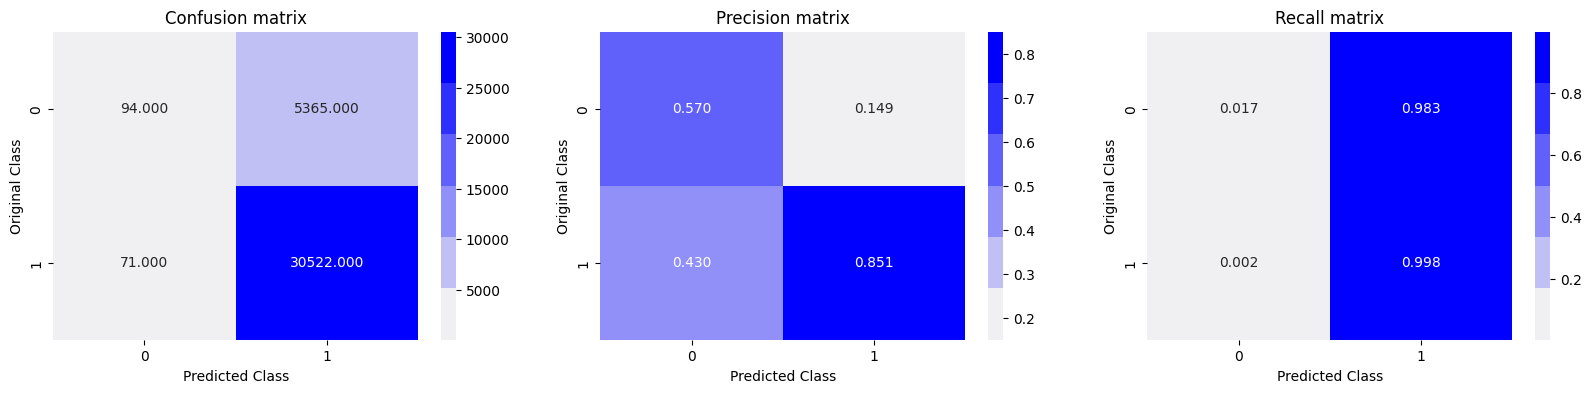

In [51]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(X_tr_set2, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr_set2, y_train)

predict_y = sig_clf.predict_proba(X_tr_set2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(X_te_set2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [52]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.210329,0.010547,0.005398,0.000485,l2,0.01,"{'penalty': 'l2', 'alpha': 0.01}",0.579289,0.584722,0.584587,...,0.584626,0.004024,2,0.590385,0.589337,0.588371,0.588888,0.588013,0.588999,0.000826
1,0.170725,0.004879,0.004975,0.000215,l2,10,"{'penalty': 'l2', 'alpha': 10}",0.543660,0.546471,0.547049,...,0.546936,0.003709,6,0.547720,0.547080,0.547027,0.547901,0.545303,0.547006,0.000918
2,1.115179,0.107982,0.004835,0.000107,l1,0.00001,"{'penalty': 'l1', 'alpha': 1e-05}",0.702374,0.700444,0.714977,...,0.710873,0.009742,1,0.803624,0.800885,0.800082,0.796615,0.797641,0.799769,0.002477
3,0.180197,0.011134,0.005236,0.000493,l2,0.1,"{'penalty': 'l2', 'alpha': 0.1}",0.550892,0.555930,0.555253,...,0.555552,0.004167,4,0.557402,0.556030,0.556317,0.557002,0.554514,0.556253,0.000996
4,0.247676,0.013457,0.003504,0.000172,l1,1,"{'penalty': 'l1', 'alpha': 1}",0.500000,0.500000,0.500000,...,0.500000,0.000000,8,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
5,0.259522,0.014200,0.004817,0.000325,l1,0.001,"{'penalty': 'l1', 'alpha': 0.001}",0.571903,0.580132,0.573068,...,0.574130,0.003514,3,0.581049,0.576432,0.573686,0.576174,0.568292,0.575127,0.004163
6,0.210918,0.008222,0.003475,0.000132,l1,10,"{'penalty': 'l1', 'alpha': 10}",0.500000,0.500000,0.500000,...,0.500000,0.000000,8,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
7,0.173974,0.013683,0.004818,0.000116,l2,1,"{'penalty': 'l2', 'alpha': 1}",0.544504,0.547791,0.548129,...,0.548084,0.003837,5,0.549053,0.548238,0.548253,0.549118,0.546484,0.548229,0.000950
8,0.219128,0.012079,0.003729,0.000217,l1,0.1,"{'penalty': 'l1', 'alpha': 0.1}",0.500000,0.500000,0.500000,...,0.500000,0.000000,8,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
9,0.254061,0.004218,0.004277,0.000284,l1,0.01,"{'penalty': 'l1', 'alpha': 0.01}",0.544628,0.527846,0.529134,...,0.540584,0.011056,7,0.550006,0.530247,0.529926,0.550251,0.546736,0.541433,0.009348


In [53]:
lra_results = results.sort_values(['param_alpha'])
lrp_results = results.sort_values(['param_penalty'])
train_auc= list(results['mean_train_score'])
train_auc_std= list(results['std_train_score'])
cv_auc = results['mean_test_score']
cv_auc_std= results['std_test_score']

### Model Training, Predictions

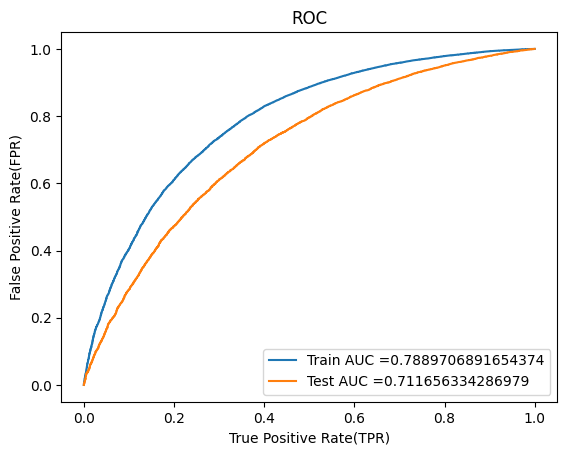

In [55]:
lr = SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log_loss', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

lr.fit(X_tr_set2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(lr, X_tr_set2)
y_test_pred = batch_predict(lr, X_te_set2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("ROC")
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

`Conclusion : Looks like we are overfitting a little bit`

### Model Evaluation

In [56]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

y_pred_train2 = predict_with_best_t(y_train_pred, best_t)

y_pred_test2 = predict_with_best_t(y_test_pred, best_t)

the maximum value of tpr*(1-fpr) 0.5166359289175491 for threshold 0.84


#### Evaluation on Train Data

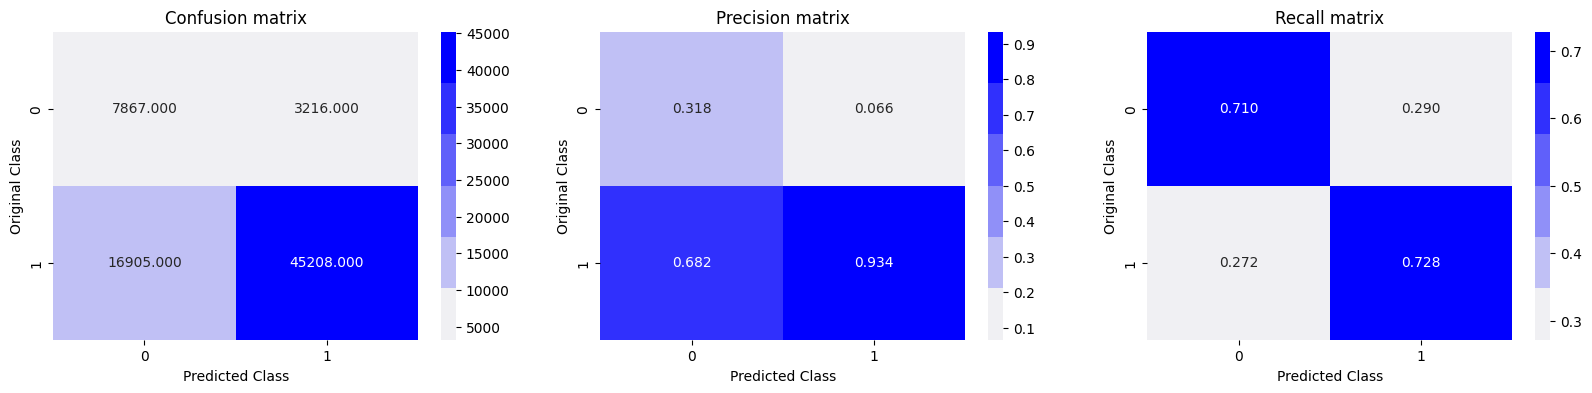

In [57]:
plot_confusion_matrix(y_train, y_pred_train2)

#### Evaluation on Test Data

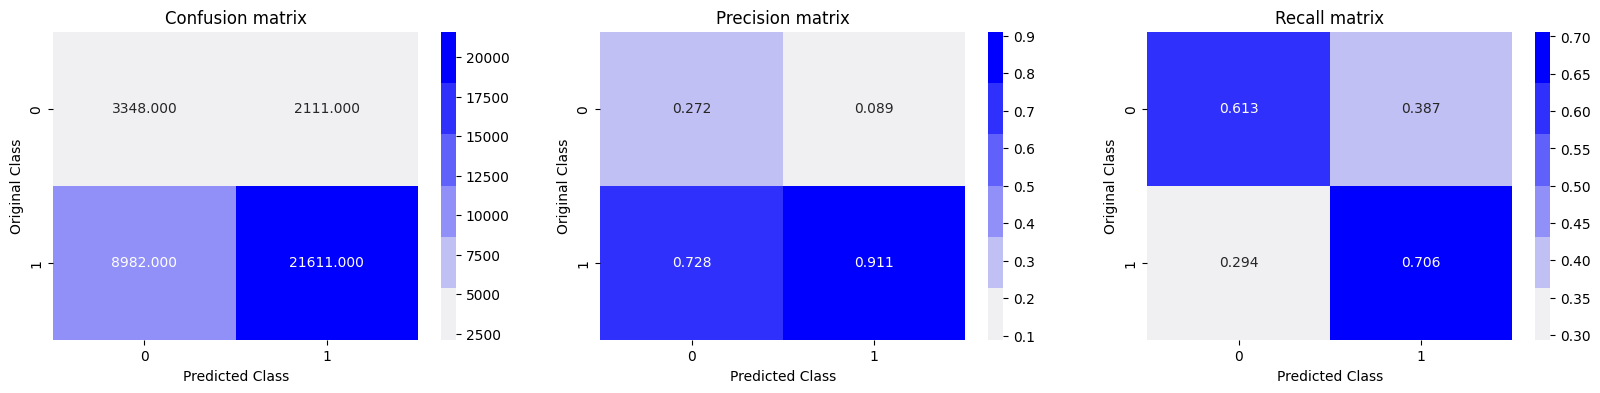

In [58]:
plot_confusion_matrix(y_test, y_pred_test2)

`Conclusion: Amazing, we are predicting less false negatives as compared to Naive Bayes`

## 4. Decision Trees

### Hyperparameter Optimization

In [60]:
dtm = tree.DecisionTreeClassifier()
parameters = {
    "max_depth": [1, 5, 10, 50, 100],
    "min_samples_leaf": [5, 10, 100, 500, 1000],
}
clf = RandomizedSearchCV(
    dtm, parameters, cv=5, scoring="roc_auc", return_train_score=True
)
clf.fit(X_tr_set2, y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)
md_results = results.sort_values(["param_max_depth"])
msl_results = results.sort_values(["param_min_samples_leaf"])

train_auc = list(results["mean_train_score"])
train_auc_std = list(results["std_train_score"])
cv_auc = results["mean_test_score"]
cv_auc_std = results["std_test_score"]
K_md = list(results["param_max_depth"])
K_msl = list(results["param_min_samples_leaf"])

In [61]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=50, min_samples_leaf=500)

In [62]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.037710,0.210479,0.008670,0.000823,1000,50,"{'min_samples_leaf': 1000, 'max_depth': 50}",0.632290,0.621740,0.631407,...,0.630627,0.004548,2,0.655021,0.653909,0.655377,0.650444,0.656117,0.654174,0.001996
1,0.674348,0.008074,0.006400,0.000310,500,1,"{'min_samples_leaf': 500, 'max_depth': 1}",0.545387,0.555735,0.545787,...,0.549867,0.003868,10,0.551631,0.550172,0.552246,0.549910,0.551338,0.551059,0.000886
2,30.635983,0.367169,0.009752,0.000632,10,50,"{'min_samples_leaf': 10, 'max_depth': 50}",0.566505,0.567707,0.548170,...,0.558221,0.007723,9,0.892453,0.890506,0.880149,0.876544,0.885578,0.885046,0.006020
3,6.577053,0.269457,0.008216,0.000783,500,50,"{'min_samples_leaf': 500, 'max_depth': 50}",0.629888,0.621860,0.628224,...,0.630972,0.006985,1,0.677063,0.672459,0.674044,0.670109,0.678596,0.674454,0.003065
4,2.822500,0.010414,0.007296,0.000328,1000,5,"{'min_samples_leaf': 1000, 'max_depth': 5}",0.594130,0.600398,0.593877,...,0.599641,0.006989,6,0.605255,0.616151,0.602348,0.613905,0.604072,0.608346,0.005579
5,5.149820,0.227603,0.010015,0.001923,1000,100,"{'min_samples_leaf': 1000, 'max_depth': 100}",0.632290,0.621740,0.631407,...,0.630627,0.004548,2,0.655021,0.653909,0.655377,0.650444,0.656117,0.654174,0.001996
6,3.030628,0.021090,0.007452,0.000651,500,5,"{'min_samples_leaf': 500, 'max_depth': 5}",0.595177,0.599854,0.591971,...,0.600338,0.007847,5,0.608310,0.618951,0.605383,0.617150,0.608093,0.611577,0.005415
7,3.411547,0.029479,0.007673,0.000628,5,5,"{'min_samples_leaf': 5, 'max_depth': 5}",0.593752,0.597541,0.592359,...,0.598494,0.008399,7,0.608718,0.619958,0.607537,0.618172,0.607893,0.612456,0.005440
8,7.079954,0.091535,0.007561,0.000194,10,10,"{'min_samples_leaf': 10, 'max_depth': 10}",0.623574,0.612533,0.621713,...,0.622815,0.005851,4,0.671417,0.674708,0.673126,0.670703,0.669182,0.671827,0.001919
9,3.373706,0.015252,0.007125,0.000232,10,5,"{'min_samples_leaf': 10, 'max_depth': 5}",0.591703,0.597034,0.592234,...,0.598313,0.008757,8,0.609734,0.620730,0.607714,0.618816,0.608472,0.613093,0.005525


### Model Training and Predictions

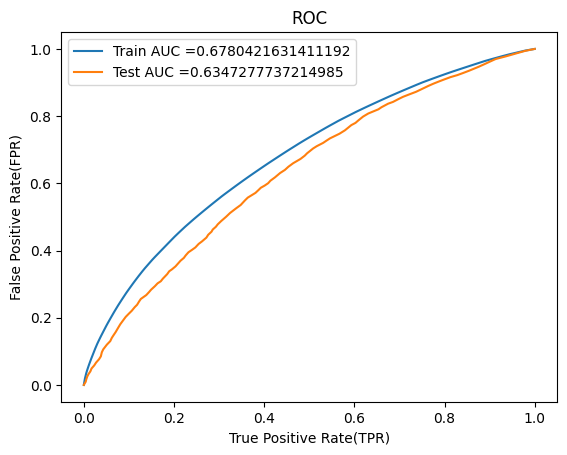

In [66]:
dtm = tree.DecisionTreeClassifier(
    ccp_alpha=0.0,
    class_weight=None,
    criterion="gini",
    max_depth=100,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=500,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    random_state=None,
    splitter="best",
)

dtm.fit(X_tr_set2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(dtm, X_tr_set2)
y_test_pred = batch_predict(dtm, X_te_set2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC =" + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("ROC")
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### Model Evaluation

In [68]:
print("=" * 100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_train_decision_tree = predict_with_best_t(y_train_pred, best_t)
y_pred_test_decision_tree = predict_with_best_t(y_test_pred, best_t)

the maximum value of tpr*(1-fpr) 0.3932592888920792 for threshold 0.843


#### Evaluation on Train Data

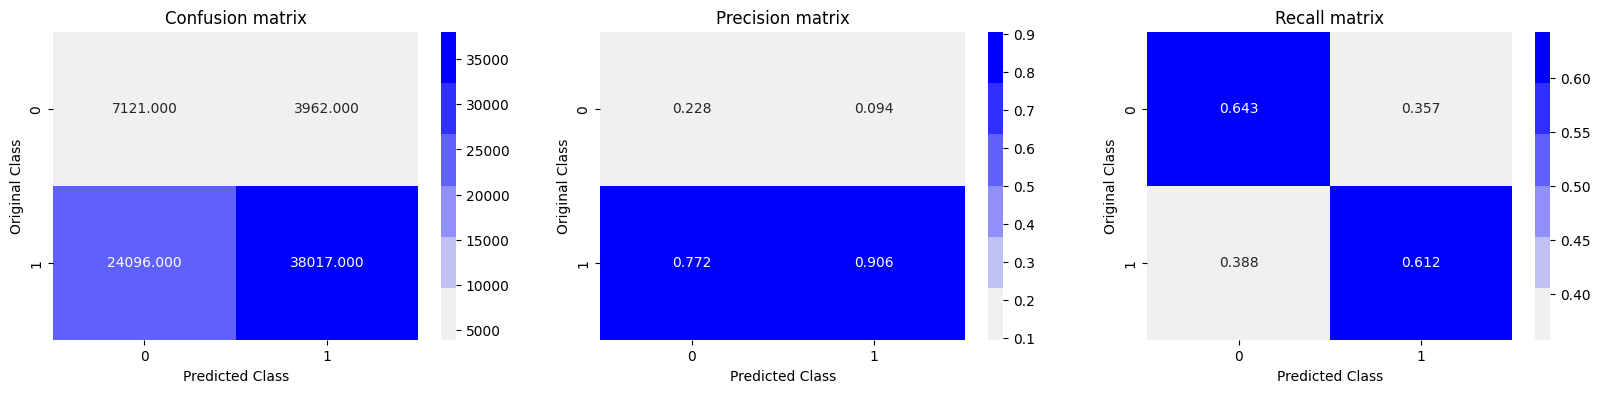

In [69]:
plot_confusion_matrix(y_train, y_pred_train_decision_tree)

#### Evaluation on Test Data

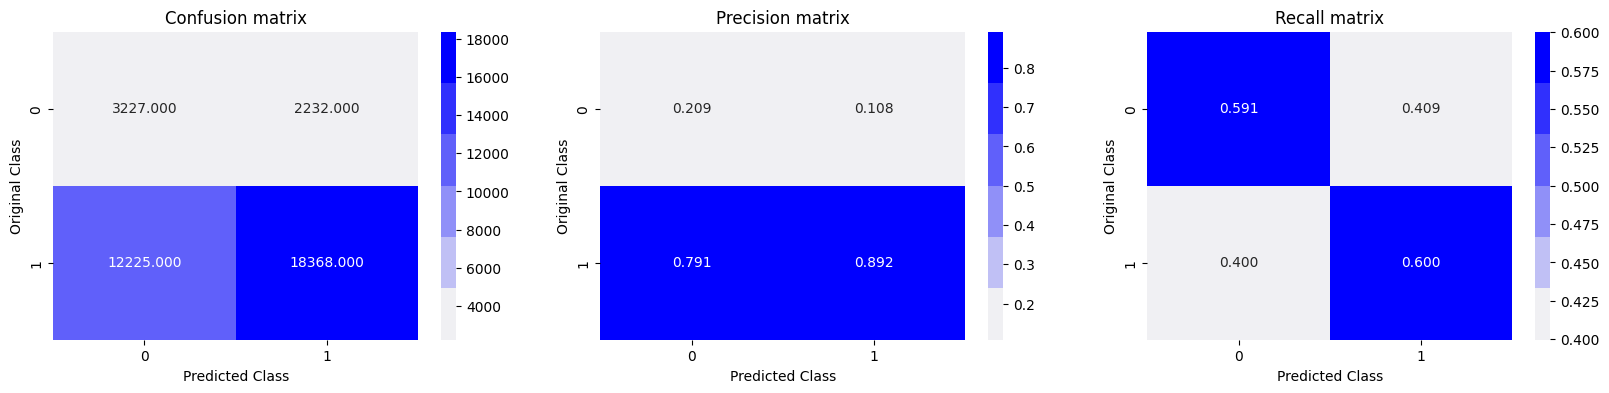

In [70]:
plot_confusion_matrix(y_test, y_pred_test_decision_tree)

## 5. Ensemble Models : Random Forest

### 5.1 Bagging : Random Forest

#### Hyperparameter Optimization

In [80]:
rf = RandomForestClassifier()
parameters = {
    "criterion": ["gini", "entropy"],
    "n_estimators": [100, 200, 500, 1000, 2000],
    "max_depth": [5, 8, 15, 25],
}
clf = RandomizedSearchCV(
    rf, parameters, cv=5, scoring="roc_auc", return_train_score=True
)
clf.fit(X_tr_set2, y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)

In [81]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,108.027271,0.925118,1.003261,0.011457,500,25,gini,"{'n_estimators': 500, 'max_depth': 25, 'criter...",0.673604,0.672758,...,0.680627,0.007541,5,0.984384,0.984417,0.984341,0.983292,0.985278,0.984342,0.000630
1,27.208913,0.285794,0.329903,0.002822,200,15,entropy,"{'n_estimators': 200, 'max_depth': 15, 'criter...",0.677785,0.677006,...,0.683280,0.006858,3,0.933885,0.933513,0.928584,0.929060,0.933531,0.931714,0.002370
2,276.287351,1.454307,3.260161,0.014280,2000,15,entropy,"{'n_estimators': 2000, 'max_depth': 15, 'crite...",0.682912,0.682512,...,0.689375,0.007261,1,0.942371,0.941220,0.941940,0.938568,0.943232,0.941466,0.001589
3,69.222908,0.439107,0.822503,0.009374,500,15,entropy,"{'n_estimators': 500, 'max_depth': 15, 'criter...",0.679612,0.682603,...,0.687365,0.007193,2,0.937189,0.937690,0.935835,0.935619,0.938701,0.937007,0.001155
4,25.515160,0.352652,0.218409,0.002108,100,25,entropy,"{'n_estimators': 100, 'max_depth': 25, 'criter...",0.667225,0.670166,...,0.678138,0.009710,6,0.994298,0.994703,0.993448,0.993277,0.993643,0.993874,0.000540
5,65.208019,0.377610,1.312006,0.009709,1000,8,entropy,"{'n_estimators': 1000, 'max_depth': 8, 'criter...",0.674076,0.675040,...,0.681178,0.007757,4,0.801599,0.799009,0.802311,0.798460,0.800072,0.800290,0.001472
6,5.721074,0.009776,0.141114,0.003906,100,8,gini,"{'n_estimators': 100, 'max_depth': 8, 'criteri...",0.655393,0.662733,...,0.664496,0.005586,10,0.763502,0.770791,0.768417,0.760555,0.772376,0.767128,0.004449
7,116.972559,1.689024,2.651268,0.061893,2000,8,gini,"{'n_estimators': 2000, 'max_depth': 8, 'criter...",0.668311,0.667685,...,0.674036,0.006906,7,0.785949,0.784597,0.782644,0.783459,0.786799,0.784690,0.001533
8,29.640266,0.183378,0.660393,0.010006,500,8,gini,"{'n_estimators': 500, 'max_depth': 8, 'criteri...",0.668375,0.664222,...,0.672506,0.006431,8,0.782776,0.778579,0.780208,0.779076,0.781620,0.780452,0.001564
9,36.286837,0.079379,1.226434,0.029773,1000,5,gini,"{'n_estimators': 1000, 'max_depth': 5, 'criter...",0.664399,0.663205,...,0.670198,0.006527,9,0.732415,0.730948,0.730027,0.727626,0.730431,0.730289,0.001558


In [82]:
# At these best_estimators we were overfitting the model to a great extend. Train AUC = 0.99 and valid_AUC = 0.69. :(
clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=2000)

#### Model Training and Predictions

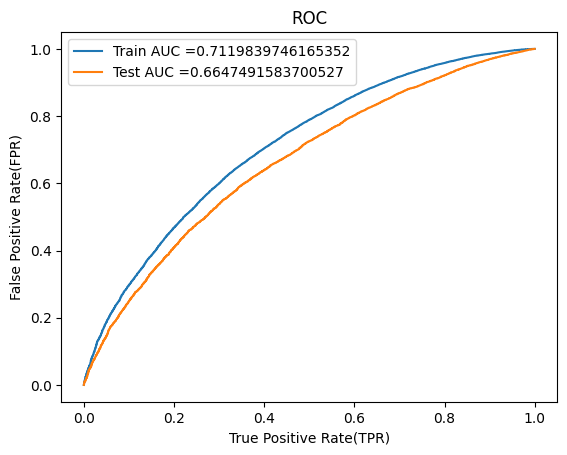

In [85]:
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(
    bootstrap=True,
    ccp_alpha=0.0,
    class_weight=None,
    criterion="gini",
    max_depth=5,
    max_features="sqrt",
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=100,
    n_jobs=None,
    oob_score=False,
    random_state=None,
    verbose=0,
    warm_start=False,
)

rf.fit(X_tr_set2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(rf, X_tr_set2)
y_test_pred = batch_predict(rf, X_te_set2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC =" + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("ROC")
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#### Model Evaluation

In [86]:
print("="*100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_train4 = predict_with_best_t(y_train_pred, best_t)
y_pred_test4 = predict_with_best_t(y_test_pred, best_t)

the maximum value of tpr*(1-fpr) 0.4269992593925036 for threshold 0.847


##### Evaluation on Train Data

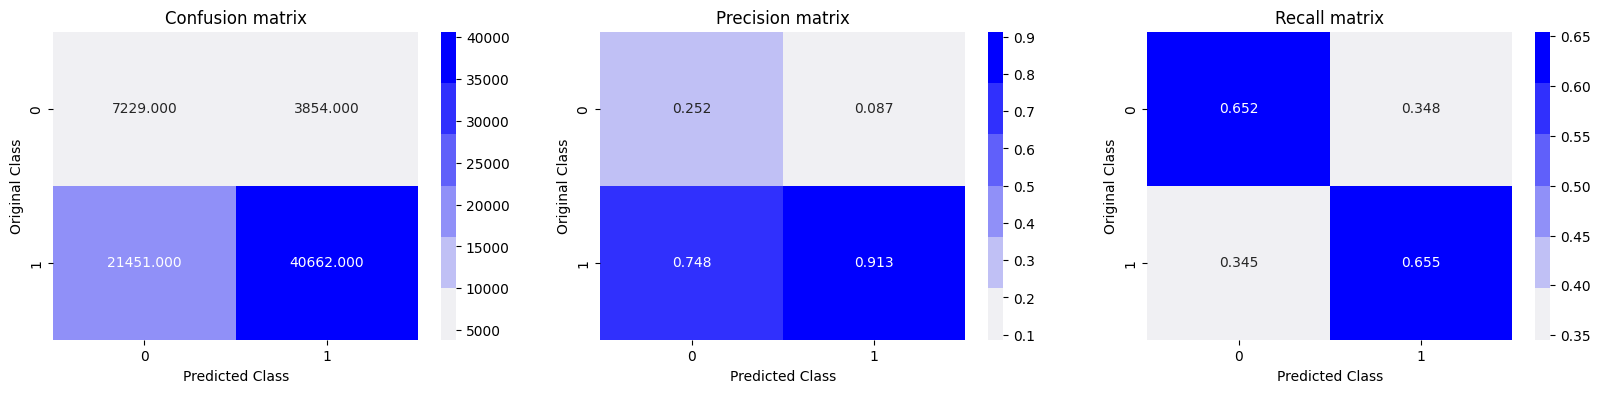

In [87]:
plot_confusion_matrix(y_train, y_pred_train4)

##### Evaluation on Test Data

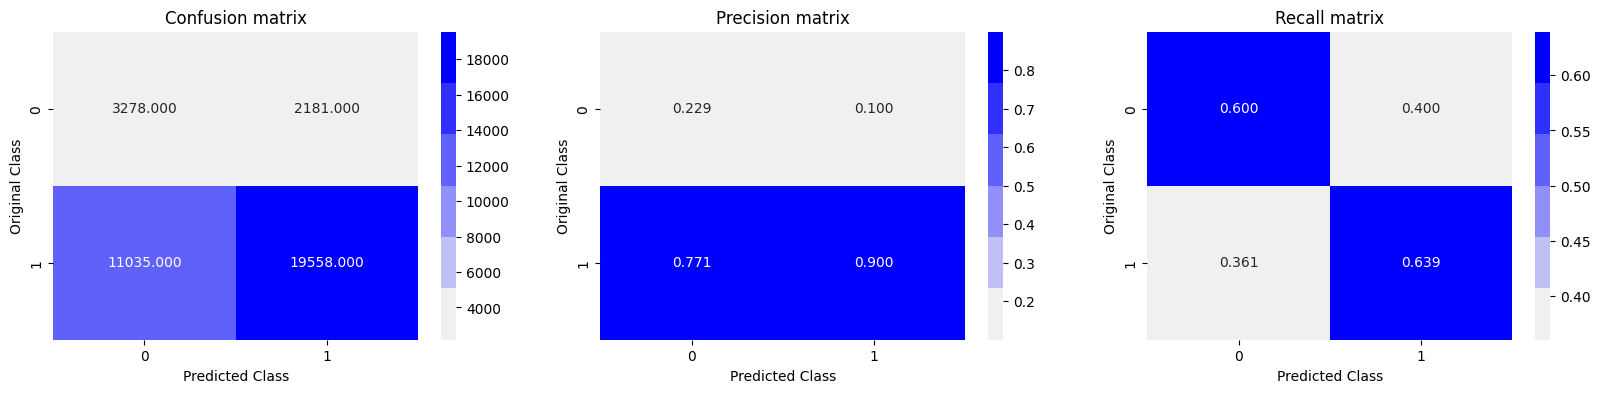

In [88]:
plot_confusion_matrix(y_test, y_pred_test4)

### 5.2 Boosting : XGBoost

In [90]:
xgb = XGBClassifier()
parameters = {'eta': [0.01,0.015, 0.025, 0.05, 0.1],
              'gamma': [0.05,0.1,0.3,0.5,0.7,0.9,1.0],
              'max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
              'min_child_weight': [1, 3, 5, 7],
              'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
              'lambda' : [0.01, 0.03, 0.05, 0.07, 0.09, 1],
              'alpha': [0, 0.1, 0.5, 1.0]
             }
clf = RandomizedSearchCV(xgb, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr_set2, y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)

#### Model Training and Predictions

In [91]:
from sklearn.metrics import roc_curve, auc

xgb = XGBClassifier(silent=False,
                      scale_pos_weight=1,
                      learning_rate=0.01,
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=5
                   )

xgb.fit(X_tr_set2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted output


[17:19:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

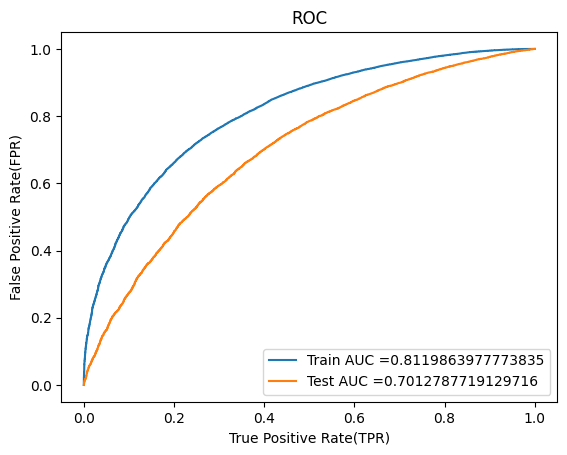

In [92]:

y_train_pred = batch_predict(xgb, X_tr_set2)
y_test_pred = batch_predict(xgb, X_te_set2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("ROC")
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

<b> Looks like the model is overfitting a little </b>

#### Model Evaluation

In [93]:
print("="*100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_train5 = predict_with_best_t(y_train_pred, best_t)
y_pred_test5 = predict_with_best_t(y_test_pred, best_t)

the maximum value of tpr*(1-fpr) 0.540469480100272 for threshold 0.834


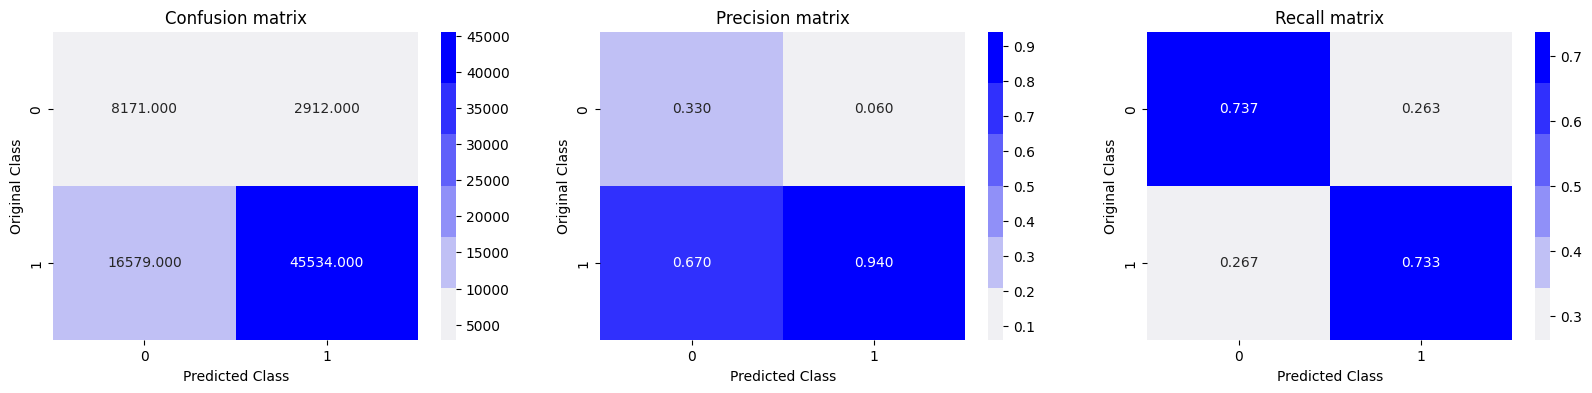

In [94]:
# Model Evaluation on Train Data
plot_confusion_matrix(y_train, y_pred_train5)

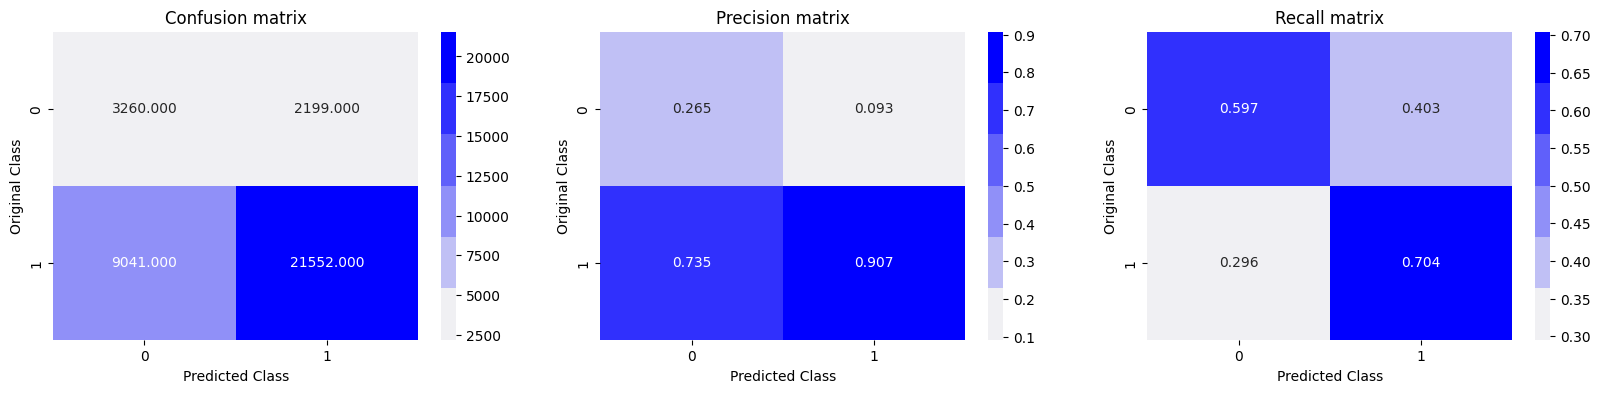

In [95]:
# Model Evaluation on Test Data
plot_confusion_matrix(y_test, y_pred_test5)

# Summary of Machine Learning Models and there perfomance

In [97]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Train AUC", "Test AUC"]
x.add_row(["TFIDF", "KNN ", "0.64", "0.58"])
x.add_row(["TFIDF", "Naive Bayes", "0.69", "0.66"])
x.add_row(["TFIDF", "Logistic Regression", "0.78", "0.71"])
x.add_row(["TFIDF", "Decision Trees", "0.69", "0.65"])
x.add_row(["TFIDF", "Random Forest", "0.72", "0.66"])
x.add_row(["TFIDF", "XGBoost", "0.81", "0.72"])

In [98]:
print(x)

+------------+---------------------+-----------+----------+
| Vectorizer |        Model        | Train AUC | Test AUC |
+------------+---------------------+-----------+----------+
|   TFIDF    |         KNN         |    0.64   |   0.58   |
|   TFIDF    |     Naive Bayes     |    0.69   |   0.66   |
|   TFIDF    | Logistic Regression |    0.78   |   0.71   |
|   TFIDF    |    Decision Trees   |    0.69   |   0.65   |
|   TFIDF    |    Random Forest    |    0.72   |   0.66   |
|   TFIDF    |       XGBoost       |    0.81   |   0.72   |
+------------+---------------------+-----------+----------+


<b> Conclusion: We can say that Logistic Regression Performs the best considering less amount of time taken by it to train the model. <b>
